# Deep Convolutional Generative Adversarial Network

### Setup

In [1]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin")

<AddedDllDirectory('C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.2/bin')>

In [2]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [3]:
tf.config.list_physical_devices()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
#from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('mixed_float16')

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import functools

from IPython import display
import pathlib

### Load and prepare the dataset

In [6]:
#(train_images, train_labels), (test_images, _) = tf.keras.datasets.cifar10.load_data()
(train_images, train_labels), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data() # Fashion accesories kerasdataset
#(train_images, train_labels), (test_images, _) = tf.keras.datasets.mnist.load_data() #handwriten digits dataset

In [7]:
print(train_images.shape, test_images.shape)

(60000, 28, 28) (10000, 28, 28)


In [8]:
max(train_labels)

9

In [9]:
def set_dataset_shape(train_images, test_images):
    train_images = np.append(train_images, test_images, axis=0)
    if len(train_images.shape) == 3:
        train_images = train_images.reshape(train_images.shape[0],train_images.shape[1], train_images.shape[2], 1)
    return train_images

train_images = set_dataset_shape(train_images, test_images)
print(train_images.shape)

(70000, 28, 28, 1)


In [10]:
train_images = train_images.astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Get the attributes of the images

In [11]:
BUFFER_SIZE = train_images.shape[0]
HEIGHT = train_images.shape[1] #Must be a multiple of 4
assert HEIGHT % 4 == 0
WIDTH = train_images.shape[2] #Must be a multiple of 4
assert WIDTH % 4 == 0
CHANNELS = train_images.shape[3]
BATCH_SIZE = 32
EPOCHS = int(BUFFER_SIZE / BATCH_SIZE) * 4
IMG_SIZE=HEIGHT*WIDTH*CHANNELS

In [12]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
for image in train_dataset.take(1):
  print(image.shape)

(32, 28, 28, 1)


###Visualize a sample from the dataset


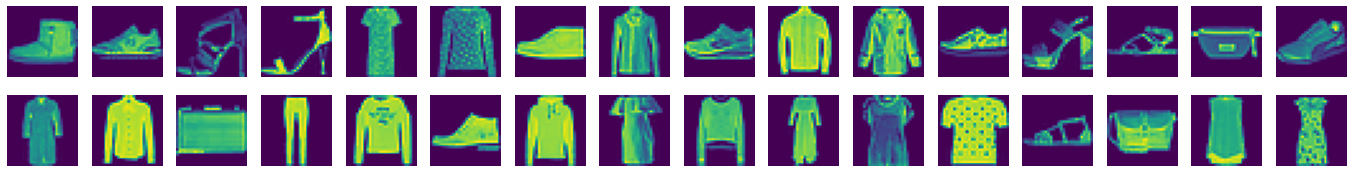

In [15]:
plt.figure(figsize=(24, 3))
for images in train_dataset.take(1): #take(): Creates a Dataset with at most count elements from this dataset.
  for i in range(32):
    ax = plt.subplot(2, 16, i + 1)
    plt.imshow((images[i].numpy()*127.5+127.5).astype('int'))
    plt.axis("off")

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of Width x Height x Channels. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [16]:
def make_generator_model():
    
    filters = 256
    initializer = tf.keras.initializers.HeNormal()
    #initializer = 'glorot_uniform'
    #activation = tf.keras.layers.LeakyReLU()
    #activation = tf.keras.layers.ReLU()
    
    model = tf.keras.Sequential()
    model.add(layers.Dense(HEIGHT//4*WIDTH//4*filters, kernel_initializer=initializer, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #model.add(layers.Dropout(0.2))

    model.add(layers.Reshape((HEIGHT//4, WIDTH//4, filters)))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, filters)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(filters, (3,3), strides=(1, 1), padding='same', kernel_initializer=initializer, use_bias=False))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, filters)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2DTranspose(filters, (3,3), strides=(1, 1), padding='same', kernel_initializer=initializer, use_bias=False))
    assert model.output_shape == (None, HEIGHT//4, WIDTH//4, filters)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2DTranspose(filters, (3,3), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=False))
    assert model.output_shape == (None, HEIGHT//2, WIDTH//2, filters)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2DTranspose(filters, (3,3), strides=(1, 1), padding='same', kernel_initializer=initializer, use_bias=False))
    assert model.output_shape == (None, HEIGHT//2, WIDTH//2, filters)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2DTranspose(CHANNELS, (3,3), strides=(2, 2), padding='same', kernel_initializer=initializer, use_bias=True, activation='tanh', kernel_regularizer='l2'))
    assert model.output_shape == (None, HEIGHT, WIDTH, CHANNELS)

    return model

Use the (as yet untrained) generator to create an image.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 256)         589824    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 256)         0

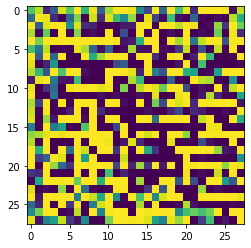

In [17]:
generator = make_generator_model()
generator.summary()

noise = tf.random.normal([1, 100])

generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow((generated_image[0].numpy()*127.5+127.5).astype('int'))

### The Discriminator

The discriminator is a CNN-based image classifier.

Observations:
1. Filters and kernel size follow an inverse proportional relationship. Or remain constant.

2. A change in strides does not impact much the generated output.

3. Does the number of layers impact performance and output quality? an increase in the number of layers, decreases performance. The output image is better defined, as if it has a better control over the distribution of pixels.

4. Does the droput rate increase image quality? (droput rate could correlate with decreased creativity vs increased fidelity.)

In [18]:
def make_discriminator_model():
    
    filters = 128
    initializer = tf.keras.initializers.HeNormal()
    #initializer = 'glorot_uniform'
    #activation = layers.LeakyReLU()
    #activation = layers.Activation('relu')
    
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(filters, (3,3), strides=(1,1), padding='same', kernel_initializer=initializer, input_shape=[HEIGHT, WIDTH, CHANNELS]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(filters, (3,3), strides=(1,1), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Conv2D(filters, (3,3), strides=(2,2), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(filters, (3,3), strides=(1,1), padding='same', kernel_initializer=initializer))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))

    model.add(layers.Flatten())

    model.add(layers.Dense(1, activation='sigmoid', kernel_initializer=initializer, kernel_regularizer='l2', use_bias = True))

    return model

In [19]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator(generated_image)
print(decision.shape)
print('Sample output: ', decision)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 28, 28, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 28, 28, 128)      

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss # Pending: Incorporate gradient penalty. Lambda gradient penalty factor.
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [23]:
# Learning rate exponential decay
initial_learning_rate = 1e-4

lr_schedule_discriminator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=EPOCHS//1,
    decay_rate=0.9,
    staircase=False)

In [24]:
# Learning rate exponential decay
initial_learning_rate = 1e-3

lr_schedule_generator = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=EPOCHS//1,
    decay_rate=0.9,
    staircase=False)

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1 = 0.0) #lr=1e-3
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1 = 0.0) #lr=1e-4

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [26]:
#checkpoint_dir = os.path.join(data_dir,'training_checkpoints')
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [27]:

noise_dim = 100
num_examples_to_generate = 4*32

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [28]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True) 
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss,disc_loss

In [29]:
history = []

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)

    # Update the progress bar
    history.append([gen_loss.numpy().mean(),disc_loss.numpy().mean()])

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
    # Visualize Generator & Discriminator Loss
    plotter(history,epoch)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  plotter(history,epoch)

**Train loss plotter**

In [30]:
def plotter(history,epoch):

  x=np.arange(len(history))
  history=np.array(history)
  gen_loss = history[:,0]
  disc_loss = history[:,1]

  plt.figure(figsize=(24, 4)) 
  plt.title('Generator & Discriminator Loss')
  
  plt.subplot(1, 2, 1)
  plt.plot(x, gen_loss, label='Generator Loss')
  plt.legend(loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(x, disc_loss, label='Discriminator Loss')
  plt.legend(loc='upper left')

  plt.show()

**Generate and save images**


In [31]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(48,2*3))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 32, i+1)
      plt.imshow((predictions[i].numpy()*127.5+127.5).astype('int') )
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()














## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated images will look increasingly real. After about n epochs, they resemble something real. 

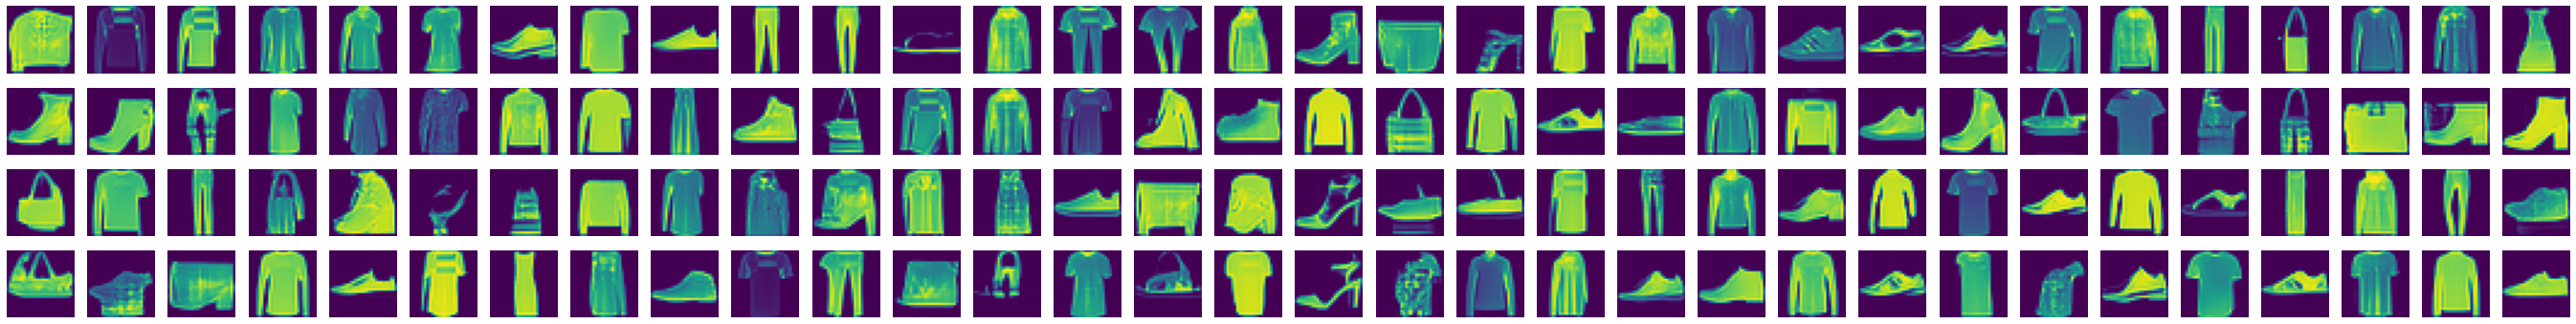

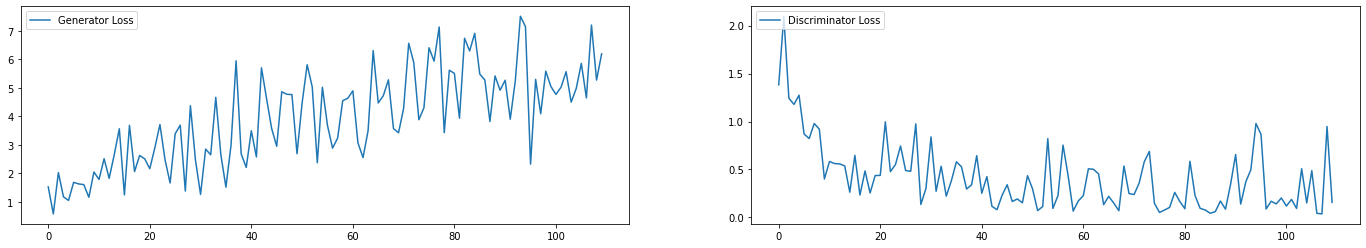

Time for epoch 110 is 51.34398531913757 sec


In [ ]:
train(train_dataset, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

![SegmentLocal](dcgan.gif "segment")

<img src="dcgan.gif" width="750" align="center">